<a href="https://colab.research.google.com/github/karlmaji/pytorch_learning/blob/master/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install einops

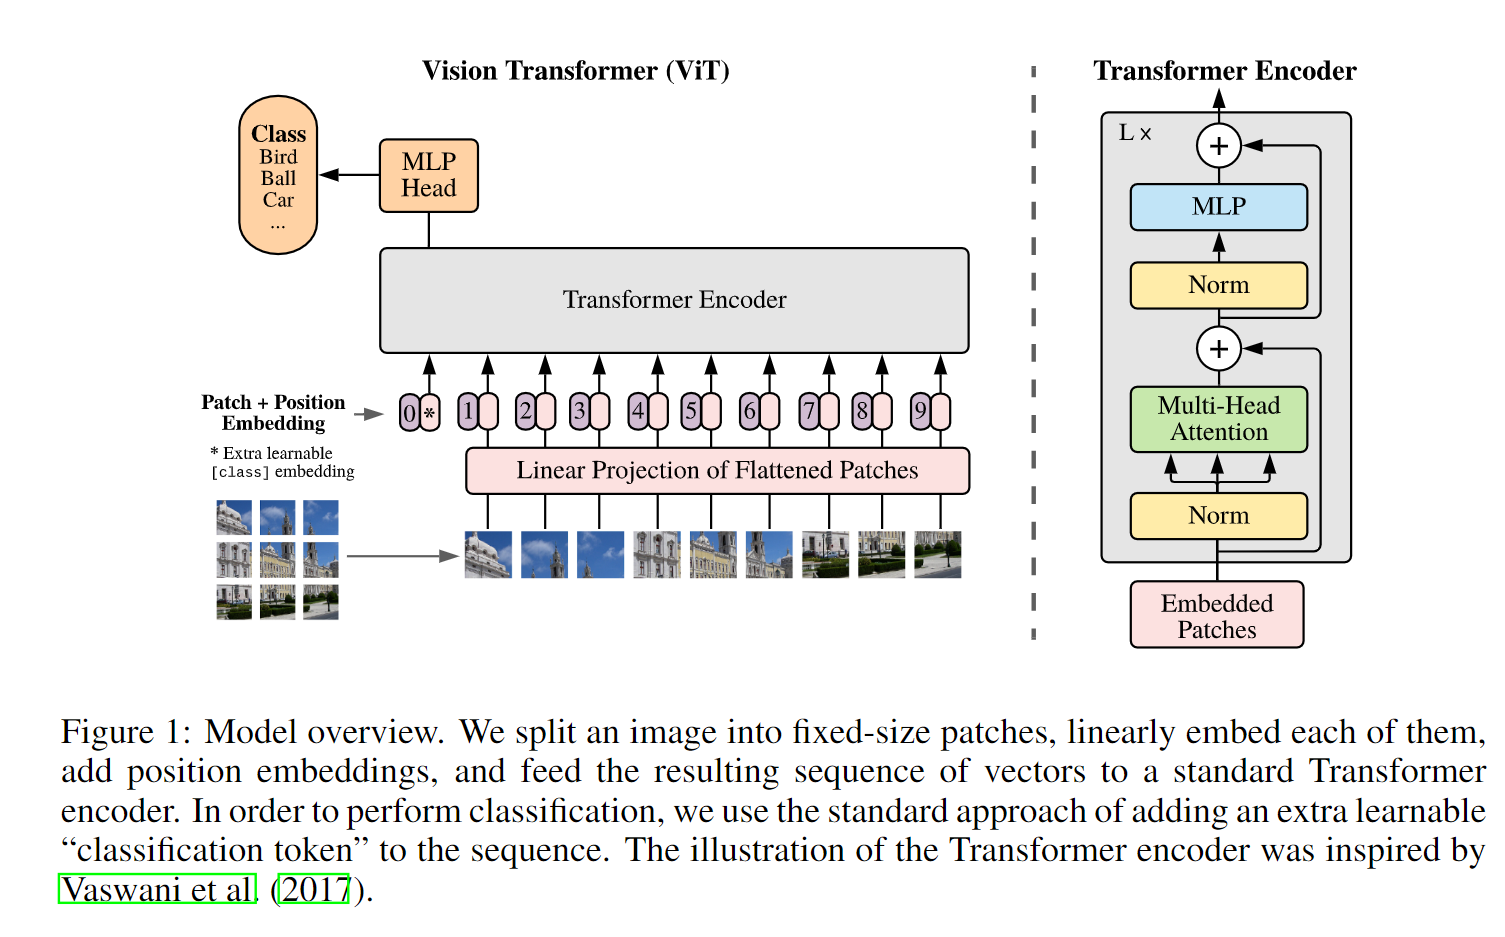

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import pandas as pd
from einops import rearrange,repeat,reduce
from einops.layers.torch import Rearrange

def set_seed(seed):
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

  
set_seed(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False


In [51]:
#搭建多头注意力机制
class Multi_Head_Attention(nn.Module):
  def __init__(self,d_model,num_head,dropout=0.):
    super(Multi_Head_Attention,self).__init__()
    self.num_head = num_head
    self.proj_linear = nn.Linear(d_model,3*d_model,bias=False)
    self.final_linear = nn.Sequential(
        nn.Linear(d_model, d_model),
        nn.Dropout(dropout)
    )
  def forward(self,x,with_mask=None):
    bs,seq_len,model_dim = x.shape
    num_head = self.num_head
    head_dim = model_dim // num_head
    proj_out = self.proj_linear(x)
    q,k,v = rearrange(proj_out,'bs sql (qkv num_head head_dim) -> qkv (bs num_head) sql head_dim'\
                      ,qkv=3,num_head = num_head)
    
    if with_mask ==None:
      atten_prob = F.softmax(torch.einsum('bsd,bkd->bsk',[q,k])/(head_dim **-0.5),dim=-1)
    else:
      mask = torch.tile(with_mask,(num_head,1,1))
      atten_prob = F.softmax(torch.einsum('bsd,bkd->bsk',[q,k])/(head_dim **-0.5) + mask,dim=-1)
      #atten_prob shape:[(bs num_head) , sql ,sql]
      # v shape :[(bs num_head) sql head_dim]
    out = torch.einsum('bsq,bqd->bsd',[atten_prob,v])
    out = rearrange(out , '(bs num_head) sql head_dim -> bs sql (num_head head_dim)',num_head = num_head)
    final_out = self.final_linear(out)
    return out

In [125]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,model_dim,num_head,mlp_dim,dropout):
    super(TransformerEncoderLayer,self).__init__()
    self.Norm1 = nn.LayerNorm(model_dim)
    self.MHA = Multi_Head_Attention(model_dim,num_head,dropout)
    self.Norm2 = nn.LayerNorm(model_dim)
    self.MLP = nn.Sequential(
        nn.Linear(model_dim,mlp_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_dim,model_dim),
        nn.Dropout(dropout)
    )
  def forward(self,x):
    x = self.MHA(self.Norm1(x)) + x 
    x = self.MLP(self.Norm2(x)) + x
    return x


def pair(t):
  return t if isinstance(t,tuple) else (t,t)


class Vision_Transformer(nn.Module):
  def __init__(self,input_channel,num_class,img_size,patch_size,model_dim,depth,num_head,mlp_dim,emb_dropout,transformer_dropout,pool='cls'):
    super(Vision_Transformer,self).__init__()

    image_height, image_width = pair(img_size)
    patch_height, patch_width = pair(patch_size)
    patch_dim = input_channel * patch_height * patch_width
    num_patches = (image_height // patch_height) * (image_width // patch_width)
    assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

    self.to_patch_embedding = nn.Sequential(
        Rearrange('b c (h h1) (w w1) -> b (h w) (c h1 w1)',h1=patch_height,w1=patch_width),
        nn.Linear(patch_dim,model_dim),
    )
    self.position_embedding = nn.Parameter(torch.randn(num_patches+1,model_dim))
    self.cls_token = nn.Parameter(torch.randn(1,1,model_dim))

    self.emb_dropout = nn.Dropout(emb_dropout)

    self.transformer_encoder = nn.Sequential(
        *[TransformerEncoderLayer(model_dim,num_head,mlp_dim,transformer_dropout) for i in range(depth)],
    )
    self.pool = pool
    self.head = nn.Sequential(
        nn.LayerNorm(model_dim),
        nn.Linear(model_dim,num_class)
    )

    

  def forward(self,x):
    x = self.to_patch_embedding(x)
    bs,n,dim = x.shape

    #cls_token = torch.tile(self.cls_token,(bs,1,1))
    cls_token = repeat(self.cls_token,'1 1 dim->bs 1 dim',bs=bs)
    x = torch.cat([cls_token,x],dim=1)

    #position = torch.tile(self.position_embedding,(bs,1,1))

    x += self.position_embedding[:n+1]

    x = self.emb_dropout(x)

    x = self.transformer_encoder(x)

    x = x.mean(dim=1) if self.pool=='mean' else x[:,0]
    
    x = self.head(x)

    return x



In [126]:
model = Vision_Transformer(input_channel=3,num_class=1000,img_size=224,patch_size=16,model_dim=80,depth=4,num_head=2,mlp_dim=160,emb_dropout=0.1,transformer_dropout=0.1,pool='mean')

In [127]:
x = torch.randn(5,3,224,224)
#torch.tile(x,(4,1,1)).shape

model(x).shape

torch.Size([5, 1000])